In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.units as u
from astropy.table import Table
from scipy.optimize import least_squares
from gunagala import camera, optical_filter, optic, psf, sky, imager

/Users/lspitler/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
rcParams['figure.figsize'] = 12, 8
rcParams['text.usetex'] = False

## Space Eye model

We just use the model already in `gunagala`, for the 90 mm refractor with 2 narrowband filters (on & off) and two broadband filters (i, z).

In [4]:
defaults = imager.create_imagers()

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [5]:
space_eye_nb = defaults['ase_2017']

In [6]:
space_eye_nb.filters

{'ase_i1': <gunagala.optical_filter.Filter at 0x11807e390>,
 'ase_nb855': <gunagala.optical_filter.Filter at 0x1180cd128>,
 'ase_nb858': <gunagala.optical_filter.Filter at 0x1180c8eb8>,
 'ase_z3': <gunagala.optical_filter.Filter at 0x11808ca58>}

## SkyHopper model

Here we construct an approximate performance model programmatically.

### Sky background

As an optical-infrared space telescope the dominant sky background for SkyHopper will be the Zodiacal Light. We can use the model from `gunagala`.

In [7]:
zl = sky.ZodiacalLight()

### Telescope

SkyHopper has a ~100 x 200 mm primary mirror, but a primary baffle is planned that will give a kidney bean shaped effective aperture of somewhat less area. `gunagala` currently only supports circular apertures.  For a simple signal to noise calculation assume the effective collecting area is twice that of Space Eye. Throughput is set so that the eventual end-to-end efficiency matches the ~40% figure given for SkyHopper.  The focal length is set to give 4 arcsecond/pixel sampling.

In [8]:
ws = [800, 1800] * u.nm
tps = [0.6, 0.6] * u.dimensionless_unscaled
sktp = Table(data = [ws, tps], names=['Wavelength', 'Throughput'])
sktp.write('skyhopper_tp.csv', overwrite=True)

After creating the `skyhopper_tp.csw` file it must be copied to/linked from the `gunagala` performance data directory.

In [9]:
skyhopper_scope = optic.Optic(aperture=90 * 2**0.5 * u.mm,
                              focal_length=(18 * u.micron / (4 * u.arcsecond)).to(u.mm,
                                                                                  equivalencies=u.equivalencies.dimensionless_angles()),
                              throughput='skyhopper_tp.csv')

In [10]:
skyhopper_scope.focal_length

<Quantity 928.1916281119335 mm>

### Image sensor

SkyHopper will use a Teledyne Hawaii-2RG, 1.7 micron cutoff version. The official specifications (http://www.teledyne-si.com/products/Documents/H2RG%20Brochure%20-%20September%202017.pdf) only give 'minimum' and 'goal' values, which are themselves lower limits.  Here we use the goal values, and assume correlated double sampling readout at 100kHz pixel readout rate, using all 32 readout channels.

Space Eye would probably benefit considerably from up-the-ramp sampling readout, if the SkyHopper image sensor electronics will support it.

For this calculation we only consider the z' channel, which uses 1/4 of the image sensor (2048 x 512 pixels).

In [11]:
ws = [800, 1000, 1230, 1500, 1700, 1800] * u.nm
qes = [0.7, 0.7, 0.8, 0.8, 0.8, 0.0] * u.dimensionless_unscaled
h2rgqe = Table(data = [ws, qes], names=['Wavelength', 'QE'])
h2rgqe.write('hawaii_2rg_qe.csv', overwrite=True)

After creating the `hawaii_2rg_qe.csv` file it must be copied to/linked from the `gunagala` performance data directory.

In [12]:
hawaii2rg = camera.Camera(bit_depth=16,
                          full_well=100000 * u.electron / u.pixel,
                          gain=2 * u.electron / u.adu,
                          bias=0 * u.adu / u.pixel,
                          readout_time=1.25 * u.second,
                          pixel_size=18 * u.micron / u.pixel,
                          resolution=(2048, 512) * u.pixel,
                          read_noise=15 * u.electron / u.pixel,
                          dark_current= 0.01 * u.electron / (u.pixel * u.second),
                          QE='hawaii_2rg_qe.csv',
                          minimum_exposure=1.25 * u.second)

### Filters

To accommodate Space Eye science in the SkyHopper design we would add two narrowband filters to the z' channel of SkyHopper, dividing the focal plane equally between these three filters.  In the absence of the actual SkyHopper filter profiles we'll use the Chebyshev model from `gunagala`.

In [13]:
skyhopper_z = optical_filter.Filter(chebyshev_params={'order': 75,
                                                      'peak': 0.95 * u.dimensionless_unscaled,
                                                      'ripple': 0.05,
                                                      'wave1': 810 * u.nm,
                                                      'wave2': 940 * u.nm},
                                    apply_aoi=True)

skyhopper_nb_on = space_eye_nb.filters['ase_nb855']
skyhopper_nb_off = space_eye_nb.filters['ase_nb858']

In [14]:
skyhopper_z.lambda_c

<Quantity 875.1048631076308 nm>

In [15]:
skyhopper_z.FWHM

<Quantity 132.79339493552106 nm>

### Point spread function

The SkyHopper PSF core is expected to be around 4 arcseconds, due to a combination of spacecraft pointing jitter and optical abberations. Use a simple Moffat profile with default shape parameter for now.

In [18]:
skyhopper_psf = psf.MoffatPSF(FWHM=4.0 * u.arcsecond)

In [19]:
psf


<module 'gunagala.psf' from '/Users/lspitler/miniconda3/lib/python3.6/site-packages/gunagala-0.1.dev459-py3.6.egg/gunagala/psf.py'>

### Construct instrument model

In [20]:
skyhopper = imager.Imager(optic=skyhopper_scope,
                          camera=hawaii2rg,
                          filters={'z_prime': skyhopper_z,
                                   'nb_on': skyhopper_nb_on,
                                   'nb_off': skyhopper_nb_off},
                          psf=skyhopper_psf,
                          sky=zl,
                          num_imagers=1)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


## End to end efficiencies comparison

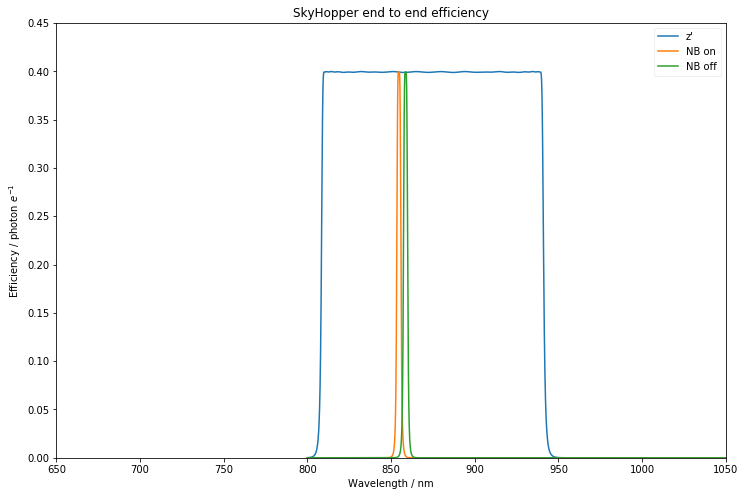

In [21]:
plt.plot(skyhopper.wavelengths, skyhopper.efficiencies['z_prime'], label="z'")
plt.plot(skyhopper.wavelengths, skyhopper.efficiencies['nb_on'], label='NB on')
plt.plot(skyhopper.wavelengths, skyhopper.efficiencies['nb_off'], label='NB off')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('SkyHopper end to end efficiency')
plt.xlim(650, 1050)
plt.ylim(0, 0.45);

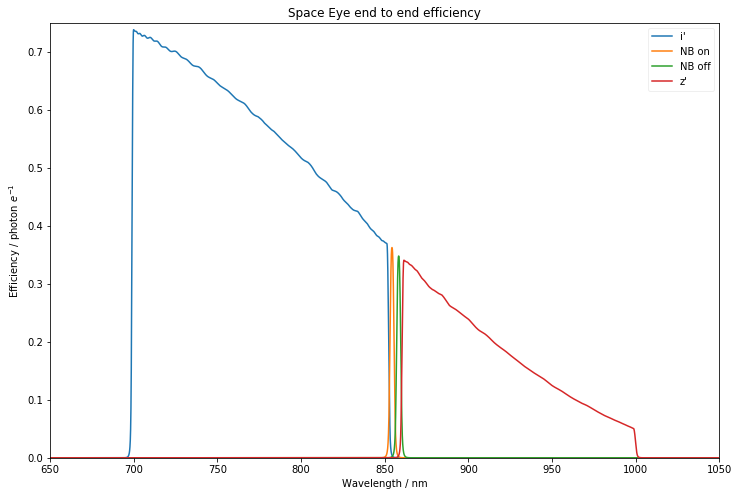

In [22]:
plt.plot(space_eye_nb.wavelengths, space_eye_nb.efficiencies['ase_i1'], label="i'")
plt.plot(space_eye_nb.wavelengths, space_eye_nb.efficiencies['ase_nb855'], label='NB on')
plt.plot(space_eye_nb.wavelengths, space_eye_nb.efficiencies['ase_nb858'], label='NB off')
plt.plot(space_eye_nb.wavelengths, space_eye_nb.efficiencies['ase_z3'], label="z'")

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('Space Eye end to end efficiency')
plt.xlim(650, 1050)
plt.ylim(0, 0.75);

At the crucial Calcium triplet wavelengths the end to end efficiencies of the two instruments are extremely similar. SkyHopper has a higher QE image sensor, but lower throughput reflective optics.

## Point source sensitivity comparison

In [23]:
skyhopper.point_source_limit(total_exp_time=600*u.second,
                             sub_exp_time=600*u.second,
                             filter_name='z_prime',
                             snr_target=5.0)

<Magnitude 19.750032572316822 mag(AB)>

The SkyHopper webpage gives a limit of 19.5 for these parameters in H band, so this for z' seems plausible.

In [24]:
space_eye_nb.point_source_limit(total_exp_time=600*u.second,
                                sub_exp_time=600*u.second,
                                filter_name='ase_i1',
                                snr_target=5.0)

<Magnitude 20.444297140456314 mag(AB)>

In [25]:
space_eye_nb.point_source_limit(total_exp_time=600*u.second,
                                sub_exp_time=600*u.second,
                                filter_name='ase_z3',
                                snr_target=5.0)

<Magnitude 19.318092928918794 mag(AB)>

In single exposures the point souce sensitivity of Space Eye is comparable. This is not entirely unexpected, SkyHopper has twice the collecting area but higher read noise.

## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. ASE aims to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodiacal Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodiacal Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from ASE. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.

### Cosmic Infrared Background estimate

We base this on the lower limits for the integrated galactic light (IGL) from Driver et al 2017. There are expressed in terms of total flux for each band so we need to divide by the filter bandwidths to convert these to a band averaged spectral flux density, convert to photon based units and then interpolate the spectral energy distribution across the Space Eye wavelength range.

In [26]:
cib_waves = (749, 895) * u.nm # Pivot wavelengths of the filters used
cib_limit = (9.35, 9.98) * u.W * u.m**-2 * u.sr**-1 / 1e9 # Lower limits, bandpass totals

In [27]:
cib_limit_sfd = (cib_limit / (150 * u.nm)).to(u.W * u.m**-2 * u.arcsecond**-2 * u.nm**-1) # Divide by bandpass
cib_limit_sfd

<Quantity [  1.46510950e-21,  1.56382811e-21] W / (arcsec2 m2 nm)>

In [28]:
cib_unsurface_brightness = cib_limit_sfd * u.arcsecond**2 # Need to change units to use spectral_density equivalencies
cib_limit_photon = cib_unsurface_brightness.to(u.photon * u.s**-1 * u.m**-2 * u.nm**-1, 
                                    equivalencies=u.equivalencies.spectral_density(cib_waves))
cib_limit_photon = cib_limit_photon / u.arcsecond**2 # Change back to surface brightness units
cib_limit_photon

<Quantity [ 0.00552427, 0.00704588] ph / (arcsec2 m2 nm s)>

In [29]:
cib_gradient = (cib_limit_photon[1] - cib_limit_photon[0]) / (cib_waves[1] - cib_waves[0])
cib_gradient = cib_gradient.to(u.photon * u.s**-1 * u.nm**-2 * u.arcsecond**-2 * u.m**-2)
cib_gradient

<Quantity 1.0421971091125006e-05 ph / (arcsec2 m2 nm2 s)>

In [30]:
cib_850 = cib_limit_photon[0] + (cib_gradient * (850 * u.nm - cib_waves[0]))
cib_850

<Quantity 0.006576892658904247 ph / (arcsec2 m2 nm s)>

In [31]:
def cib_model(wavelengths, scale=cib_850, slope=cib_gradient):
    cib = slope * (wavelengths - 850 * u.nm) + scale
    return cib.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1)

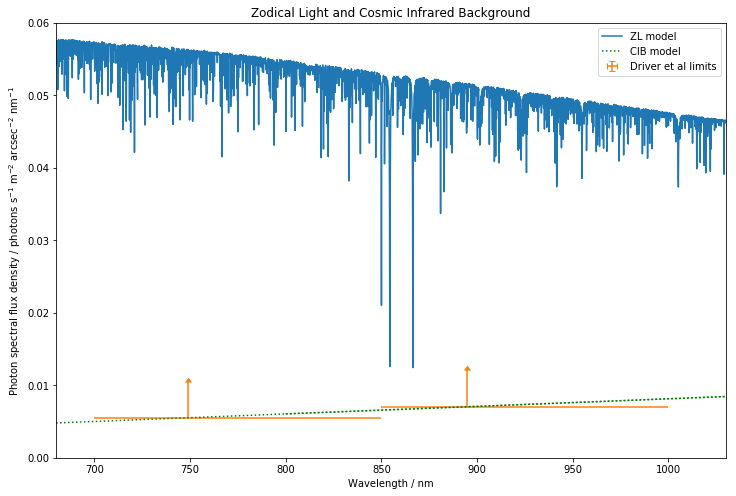

In [32]:
plt.plot(zl.waves.to(u.nm), 
         zl.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1), label='ZL model')
plt.errorbar(cib_waves.value, cib_limit_photon.value, xerr=((49,45), (101, 105)), 
             yerr=0.005, lolims=True, linestyle='none', label='Driver et al limits')
plt.plot(space_eye_nb.wavelengths, cib_model(space_eye_nb.wavelengths), 'g:', label='CIB model')
plt.plot(skyhopper.wavelengths, cib_model(skyhopper.wavelengths), 'g:')
plt.legend()
plt.xlim(680, 1030)
plt.ylim(0,0.06)
plt.title('Zodical Light and Cosmic Infrared Background')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')

### Model photometric data

We then use the Zodical Light and Cosmic Infrared Background models to predict total signal and noise as measured in the Space Eye photometric bands. The model is parameterised by the ZL flux scaling, cosmic CIB flux scaling and CIB spectral slope, all expressed relative to the nominal values used above. 

In [33]:
def model_data(zl_scaling, cib_scaling, cib_slope, 
               instrument,
               total_exposure_time,
               sub_exposure_time,
               filter_fractions,
               binning_scale,
               add_noise=False):
            
    data={}
    
    for filter_name in instrument.filter_names:
        t_exp = total_exposure_time * filter_fractions[filter_name]
        cib_signal, noise = instrument.extended_source_signal_noise(surface_brightness=lambda w: cib_model(w,
                                                                                                           cib_scaling * cib_850,
                                                                                                           cib_slope * cib_gradient),
                                                                  filter_name=filter_name,
                                                                  total_exp_time=t_exp,
                                                                  sub_exp_time=sub_exposure_time,
                                                                  calc_type='per arcsecond squared')
        
        zl_signal, noise_again = instrument.extended_source_signal_noise(surface_brightness=None,
                                                                       filter_name=filter_name,
                                                                       total_exp_time=t_exp,
                                                                       sub_exp_time=sub_exposure_time,
                                                                       calc_type='per arcsecond squared')
        
        # Spatial binning
        cib_signal = (cib_signal * binning_scale**2).to(u.electron)
        zl_signal = (zl_signal * binning_scale**2).to(u.electron)
        binning_scale = binning_scale.to(u.arcsecond)
        noise = (noise * binning_scale.value * binning_scale.unit**2).to(u.electron)
        noise_again = (noise_again * binning_scale.value * binning_scale.unit**2).to(u.electron)
    
        # Adjust noise in accordance with ZL scaling
        scaled_noise = ((zl_scaling - 1) * noise_again**2 + noise**2)**0.5
    
        if add_noise:
            # Add random noise to expectation value
            data[filter_name] = cib_signal + zl_scaling * zl_signal + \
                np.random.normal(scale=scaled_noise.value) * scaled_noise.unit
        else:
            # Return expectation value and noise
            data[filter_name] = (cib_signal + zl_scaling * zl_signal, scaled_noise)
        
    return data

#### Space Eye

Minimum mission duration of 1 year (goal 2+), at least 2 main EBL fields (1 NEP, 1 SEP), duty cycle of 40%, exposure time split equally amongst the 4 filters. 1st do a calculation of the total signal and noise per arcsecond^2 in each field for each filter.

In [34]:
mission_duration = 1 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'ase_i1': 1/4,
                    'ase_nb855': 1/4,
                    'ase_nb858': 1/4,
                    'ase_z3': 1/4}

model_data(1.0, 1.0, 1.0,
           instrument=space_eye_nb,
           total_exposure_time=mission_duration * duty_cycle / n_fields,
           sub_exposure_time=10 * u.minute,
           filter_fractions=filter_fractions,
           binning_scale=1 * u.arcsecond)

{'ase_i1': (<Quantity 53006.688643512956 electron>,
  <Quantity 254.32609002923346 electron>),
 'ase_nb855': (<Quantity 527.6438595525691 electron>,
  <Quantity 110.46590100839879 electron>),
 'ase_nb858': (<Quantity 567.3471476527712 electron>,
  <Quantity 110.64546341218677 electron>),
 'ase_z3': (<Quantity 14015.92430019469 electron>,
  <Quantity 160.28410940027547 electron>)}

#### SkyHopper

3-6? months of mission time available for EBL observations, again at least 2 fields (1 NEP, 1 SEP), duty cycle also 40%, exposure time split equally amongst 3 filters.

In [35]:
ebl_allocation = 1/4 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'z_prime': 1/3,
                    'nb_on': 1/3,
                    'nb_off': 1/3}

model_data(1.0, 1.0, 1.0,
           instrument=skyhopper,
           total_exposure_time=ebl_allocation * duty_cycle / n_fields,
           sub_exposure_time=10 * u.minute,
           filter_fractions=filter_fractions,
           binning_scale=1 * u.arcsecond)

{'nb_off': (<Quantity 433.01092900360976 electron>,
  <Quantity 114.43206905847507 electron>),
 'nb_on': (<Quantity 387.6264574238695 electron>,
  <Quantity 114.23359382171195 electron>),
 'z_prime': (<Quantity 20434.82857161518 electron>,
  <Quantity 181.9244790335132 electron>)}

### Sensitivity estimates

To estimate the signal to noise in the measurements of the zodiacal light and cosmic infrared background we use the model to generate sets of simulated data with noise then fit the model to the noisy data in order to recover the ZL flux scaling, CIB flux scaling and CIB spectral slope parameters. Using a brute force Monte Carlo method we can obtain a simple estimate of the uncertainty in the recovered parameters.

In [36]:
def residual(params, 
             data,
             instrument,
             total_exposure_time,
             sub_exposure_time,
             filter_fractions,
             binning_scale):
    
    model = model_data(params[0], params[1], params[2],
                       instrument=instrument,
                       total_exposure_time=total_exposure_time,
                       sub_exposure_time=sub_exposure_time,
                       filter_fractions=filter_fractions,
                       binning_scale=binning_scale,
                       add_noise=False)
    residuals = []
    
    for filter_name in instrument.filter_names:
        datum = data[filter_name]
        residuals.append((datum - model[filter_name][0]) / model[filter_name][1])
        
    return residuals


def simple_mc(instrument,
              total_exposure_time,
              sub_exposure_time,
              filter_fractions,
              binning_scale,
              n=200):

    parameters=[]

    for i in range(n):
        data = model_data(1.0, 1.0, 1.0,
                          instrument=instrument,
                          total_exposure_time=total_exposure_time,
                          sub_exposure_time=sub_exposure_time,
                          filter_fractions=filter_fractions,
                          binning_scale=binning_scale,
                          add_noise=True)
        fit = least_squares(residual, (1.0, 1.0, 1.0),
                            bounds=((0.9, 0.0, -5.0), (1.1, 2.0, 5.0)),
                            kwargs={'data':data,
                                    'instrument':instrument,
                                    'total_exposure_time': total_exposure_time,
                                    'sub_exposure_time': sub_exposure_time,
                                    'filter_fractions': filter_fractions,
                                    'binning_scale':binning_scale})
        parameters.append(fit.x)

    return np.array(parameters)

For these simplified calculations we will assume binning of the ZL+EBL signal over the full field of view. In reality we will fit a more sophisticated spatially dependent model with strong priors on spatial variations based on previous observations of the smoothness of the Zodiacal Light. The resulting signal to noise would be similar.

We also multiply by a masking factor to account for the proportion of the sky area that in unusable due to light from discrete sources.  This factor will depend on stray light levels and the sources in and near the actual fields chosen but for now just assume 50% in all cases.

In [37]:
space_eye_scale = (space_eye_nb.field_of_view[0] * space_eye_nb.field_of_view[1])**0.5
space_eye_scale

<Quantity 1.4461538962772391 deg>

In [38]:
skyhopper_scale = (skyhopper.field_of_view[0] * skyhopper.field_of_view[1])**0.5
skyhopper_scale

<Quantity 1.137777777777778 deg>

In [39]:
masking_factor = 0.5

#### Space Eye

##### 1 year mission:

In [40]:
mission_duration = 1 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'ase_i1': 1/4,
                    'ase_nb855': 1/4,
                    'ase_nb858': 1/4,
                    'ase_z3': 1/4}

binning_scale = space_eye_scale * masking_factor**0.5

space_eye_results = simple_mc(instrument=space_eye_nb,
                              total_exposure_time=mission_duration * duty_cycle / n_fields,
                              sub_exposure_time=10 * u.minute,
                              filter_fractions=filter_fractions,
                              binning_scale=binning_scale)

The mean values of the fitted parameters should reproduce the original model, i.e. (1.0, 1.0, 1.0)

In [41]:
space_eye_results.mean(axis=0)

array([ 1.00001001,  0.99992253,  1.00004552])

The standard deviation of the fitted parameters gives the fractional statistical uncertainty in the ZL flux scaling, CIB flux scaling and CIB spectral slope.

In [42]:
space_eye_results.std(axis=0, ddof=1)

array([ 0.000494  ,  0.00386279,  0.00163065])

##### 2 year mission

In [43]:
mission_duration = 2 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'ase_i1': 1/4,
                    'ase_nb855': 1/4,
                    'ase_nb858': 1/4,
                    'ase_z3': 1/4}

binning_scale = space_eye_scale * masking_factor**0.5

space_eye_results = simple_mc(instrument=space_eye_nb,
                              total_exposure_time=mission_duration * duty_cycle / n_fields,
                              sub_exposure_time=10 * u.minute,
                              filter_fractions=filter_fractions,
                              binning_scale=binning_scale)

space_eye_results.std(axis=0, ddof=1)

array([ 0.00033742,  0.00264054,  0.00110484])

**For a 1-2 year mission Space Eye will achieve sufficient signal to noise for a measurement of the CIB flux of 0.4-0.3% accuracy in 2 fields, assuming spatial variations (and systematic errors) can be neglected.**

#### SkyHopper

##### 3 months

In [44]:
ebl_allocation = 1/4 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'z_prime': 1/3,
                    'nb_on': 1/3,
                    'nb_off': 1/3}

binning_scale = skyhopper_scale * masking_factor**0.5

skyhopper_results = simple_mc(instrument=skyhopper,
                              total_exposure_time=ebl_allocation * duty_cycle / n_fields,
                              sub_exposure_time=10 * u.minute,
                              filter_fractions=filter_fractions,
                              binning_scale=binning_scale)

skyhopper_results.std(axis=0, ddof=1)

array([ 0.00137755,  0.00992664,  0.02701771])

##### 6 months

In [45]:
ebl_allocation = 1/2 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'z_prime': 1/3,
                    'nb_on': 1/3,
                    'nb_off': 1/3}

binning_scale = skyhopper_scale * masking_factor**0.5

skyhopper_results = simple_mc(instrument=skyhopper,
                              total_exposure_time=ebl_allocation * duty_cycle / n_fields,
                              sub_exposure_time=10 * u.minute,
                              filter_fractions=filter_fractions,
                              binning_scale=binning_scale)

skyhopper_results.std(axis=0, ddof=1)

array([ 0.00094172,  0.00681202,  0.01872675])

**For a 3-6 month EBL time allocation SkyHopper will achieve sufficient signal to noise for a measurement of the CIB flux of 1.0-0.7% accuracy in 2 fields, assuming spatial variations (and systematic errors) can be neglected.**

### Summary

Both the Space Eye and SkyHopper options appear to be able to deliver sufficient signal to noise to measure the absolute EBL flux to better than ~1% in at least 2 fields given their nominal mission durations. *Under the assumptions described above the dedicated Space Eye mission appears to offer over twice the measurement precision, however.*

### Caveats

* This analysis is based purely on a simple signal to noise model. No allowances are made for systematic errors, which will inevitably reduce the achieved measurement precision. It is expected that these would either effect the two instruments similarly, or further favour the dedicated Space Eye.
* The SkyHopper results are sensitive to assumptions about the read noise/sub-exposure time because for simple CDS readout and ~10 minute exposures the instrument is close to being read noise limited. If up the ramp sampling and/or longer exposures are possible then the apparent sensitive difference with Space Eye is diminished, e.g.:

In [46]:
ebl_allocation = 1/2 * u.year
n_fields = 2
duty_cycle = 0.4
filter_fractions = {'z_prime': 1/3,
                    'nb_on': 1/3,
                    'nb_off': 1/3}

binning_scale = skyhopper_scale * masking_factor**0.5

skyhopper_results = simple_mc(instrument=skyhopper,
                              total_exposure_time=ebl_allocation * duty_cycle / n_fields,
                              sub_exposure_time=40 * u.minute,
                              filter_fractions=filter_fractions,
                              binning_scale=binning_scale)

skyhopper_results.std(axis=0, ddof=1)

array([ 0.00052135,  0.00372039,  0.01050027])

If the effective read noise of SkyHopper is halved then the 6 month sensitivity becomes similar to the 2 year Space Eye, 0.4% vs 0.3%.